In [1]:
# https://github.com/Tony-xy-Liu/cpsc445/blob/main/hw/02/q5.ipynb

# # in R:
# gene = pbmc@assays$RNA@var.features
# x = pbmc@assays$RNA@data[gene,]
# x = t(as.matrix(x))
# write.table(x, file="pbmc.csv", sep = ',', row.names=TRUE, col.names=TRUE)
# write.table(pbmc@meta.data, file="pbmc_meta.csv", sep = ',', row.names=TRUE, col.names=TRUE)
# #renmame first index header to "cell"!

import pandas as pd
import numpy as np

df = pd.read_csv('../01/pbmc.csv')
cluster_names = ["Naive CD4 T", "CD14+ Mono", "Memory CD4 T", "B", "CD8 T", "FCGR3A+ Mono", "NK", "DC", "Platelet"]
FMONO = "FCGR3A+ Mono"
NK = "NK"
print(df.shape)
df.head()

(2638, 2000)


,PPBP,LYZ,S100A9,IGLL5,GNLY,FTL,PF4,FTH1,GNG11,S100A8,...,GADD45G,MKNK1,AURKC,VOPP1,RHOC,CISH,CD27,LILRA3,WBP5,CLIC2
AAACATACAACCAC-1,0.000000,1.635873,0.000000,0.0,0.000000,3.924095,0.0,2.226555,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,3.075915,0.0,0.0,0.0
AAACATTGAGCTAC-1,0.000000,1.962726,0.000000,0.0,0.000000,3.063189,0.0,3.574384,0.0,0.000000,...,0.000000,0.0,0.0,1.111715,0.0,0.0,1.111715,0.0,0.0,0.0
AAACATTGATCAGC-1,0.000000,1.995416,0.000000,0.0,1.429744,3.274161,0.0,3.582238,0.0,0.000000,...,1.429744,0.0,0.0,0.000000,0.0,0.0,1.429744,0.0,0.0,0.0
AAACCGTGCTTCCG-1,1.566387,4.521175,3.838845,0.0,0.000000,5.692271,0.0,5.919842,0.0,2.515108,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
AAACCGTGTATGCG-1,0.000000,0.000000,0.000000,0.0,3.453545,5.218589,0.0,3.453545,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0


In [2]:
meta = pd.read_csv('pbmc_meta.csv')
print(meta.shape)
meta.head()

(2638, 7)


,cell,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,RNA_snn_res.0.5,seurat_clusters
0,AAACATACAACCAC-1,pbmc3k,2419,779,3.017776,2,2
1,AAACATTGAGCTAC-1,pbmc3k,4903,1352,3.793596,3,3
2,AAACATTGATCAGC-1,pbmc3k,3147,1129,0.889736,2,2
3,AAACCGTGCTTCCG-1,pbmc3k,2639,960,1.743085,1,1
4,AAACCGTGTATGCG-1,pbmc3k,980,521,1.224490,6,6


## 1, (4 points) Use Welch’s t-test to test whether gene FCGR3A is differentially expressed in FCGR3A monocytes and NK cells. Also draw a violine plot of FCGR3A expression grouped by cell type.

In [3]:
from scipy import stats

def _get_cells(name: str, silent=False):
    ci = cluster_names.index(name)
    cells = meta[meta["seurat_clusters"] == ci]["cell"].values
    if not silent: print(f'number of  {name} cells:{cells.shape[0]}, cluster index:{ci}, peek:[{", ".join(str(c) for c in cells[:3])}, ...]')
    return cells

fmono_feats = df[df.index.isin(_get_cells(FMONO))]
nk_feats = df[df.index.isin(_get_cells(NK))]

res = stats.ttest_ind(fmono_feats["FCGR3A"].values, nk_feats["FCGR3A"].values, equal_var=False)
res

number of  FCGR3A+ Mono cells:162, cluster index:5, peek:[AAACGCTGTTTCTG-1, AAATCAACCCTATT-1, AAATCATGACCACA-1, ...]
number of  NK cells:155, cluster index:6, peek:[AAACCGTGTATGCG-1, AAATTCGATTCTCA-1, AACCTTACGCGAGA-1, ...]


Ttest_indResult(statistic=6.201983066702088, pvalue=1.9829015768110337e-09)

### Also draw a violine plot of FCGR3A expression grouped by cell type.

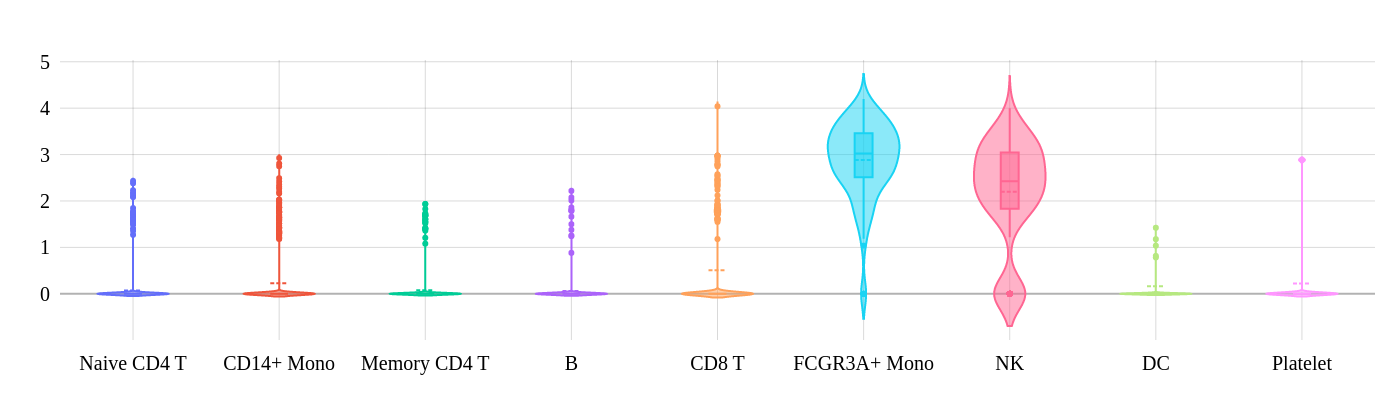

In [4]:
from plotly import graph_objects as go, subplots as sp

fig = go.Figure()
cluster_indexes = sorted(meta["seurat_clusters"].unique())
for i in cluster_indexes:
    cname = cluster_names[i]
    # if cname not in {FMONO, NK}: continue
    cells = meta[meta["seurat_clusters"] == i]["cell"].values
    feats = df[df.index.isin(cells)]
    values = np.array(feats["FCGR3A"].values, copy=True)
    fig.add_trace(
        go.Violin(
            x=[cname for _ in values], y=values,
            # name=cname,
            box_visible=True,
            meanline_visible=True,
            showlegend=False,
        ),
    )

axis_col = 'rgba(0, 0, 0, 0.15)'
zero_col = 'rgba(0, 0, 0, 0.3)'
no_col = 'rgba(0, 0, 0, 0)'

xaxis_desc: dict = dict(linecolor=no_col, gridcolor=axis_col, zerolinecolor=zero_col, zerolinewidth=2)
yaxis_desc: dict = dict(linecolor=no_col, gridcolor=axis_col, zerolinecolor=zero_col, zerolinewidth=2)
layout = dict(
    autosize=True,
    width=1400,
    height=400,
    margin=dict(
        l=60, r=25, b=60, t=60, pad=5
    ),
    # paper_bgcolor="white",
    font_family="Times New Roman",
    font_color="black",
    font_size=20,
    plot_bgcolor='white',
    xaxis=dict(**xaxis_desc, ),
    yaxis=yaxis_desc,
)
fig.update_annotations(font_size=24)
fig.update_layout(go.Layout(layout))
# fig.show()

from IPython.display import Image
Image(filename='q5_FCGR3A.png')

## 2, (6 points) For FCGR3A raw counts (UMIs), please calculate the entropy (base 2) in FCGR3A mono-cytes and across all cells.

In [5]:
# # in R:
# gene = pbmc@assays$RNA@var.features
# x = pbmc@assays$RNA@counts[gene, ]
# x = t(as.matrix(x))
# write.table(x, file="pbmc_counts.csv", sep = ',', row.names=TRUE, col.names=TRUE)

counts = pd.read_csv('pbmc_counts.csv')
counts.head()

,PPBP,LYZ,S100A9,IGLL5,GNLY,FTL,PF4,FTH1,GNG11,S100A8,...,GADD45G,MKNK1,AURKC,VOPP1,RHOC,CISH,CD27,LILRA3,WBP5,CLIC2
AAACATACAACCAC-1,0,1,0,0,0,12,0,2,0,0,...,0,0,0,0,0,0,5,0,0,0
AAACATTGAGCTAC-1,0,3,0,0,0,10,0,17,0,0,...,0,0,0,1,0,0,1,0,0,0
AAACATTGATCAGC-1,0,2,0,0,1,8,0,11,0,0,...,1,0,0,0,0,0,1,0,0,0
AAACCGTGCTTCCG-1,1,24,12,0,0,78,0,98,0,3,...,0,0,0,0,0,0,0,0,0,0
AAACCGTGTATGCG-1,0,0,0,0,3,18,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
def entropy(vec):
    vec = np.array(vec)
    uniques, counts = np.unique(vec, return_counts=True)
    p = counts/vec.shape[0]
    return np.sum(-np.log2(p)*p)

H_mono = entropy(counts[counts.index.isin(_get_cells(FMONO, silent=True))]["FCGR3A"].values)
H_all = entropy(counts["FCGR3A"].values)
print(f"FCGR3A entropy of counts in FCGR3A monocytes only: {H_mono}")
print(f"FCGR3A entropy of counts in all cells: {H_all}")

FCGR3A entropy of counts in FCGR3A monocytes only: 4.333533013686759
FCGR3A entropy of counts in all cells: 1.26858777217796
